In [1]:
import os
os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from functools import reduce
from operator import mul

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modular_splicing.eclip.data.dataset import get_eclip_dataset

In [4]:
RCS = "1, 2", "1", "2"

In [5]:
result = {}
for rc in RCS:
    for is_train in True, False:
        print(rc, is_train)
#         extract_binding_positions(is_train, pbar=tqdm.tqdm, replicate_category=rc)
        result[rc, is_train] = get_eclip_dataset(is_train, replicate_category=rc)
binding_by_motif = {}
for rc in RCS:
    binding_by_motif[rc] = np.zeros(120)
    total_size = 0
    for datum in result[rc, True]:
        total_size += reduce(lambda x, y: x * y, datum[0].shape)
        for i, v in enumerate(datum):
            binding_by_motif[rc][i] += v.count_nonzero() / 2
binding_by_motif["1 union 2"] = binding_by_motif["1"] + binding_by_motif["2"]

1, 2 True
1, 2 False
1 True
1 False
2 True
2 False


In [8]:
def plot(stat, *rcs):
    max_value = max([max(stat[x]) for x in rcs])
    for rc in rcs:
        plt.hist(stat[rc], bins=np.linspace(0, max_value, 10), alpha=0.5, label=f"Replicate {rc} [mean={np.mean(stat[rc]):.2e}]")
    plt.ylabel("Frequency")

In [9]:
RCS_adj = RCS + ("1 union 2",)

df = pd.DataFrame(
    [
        [np.mean(binding_by_motif[rc]) for rc in RCS_adj],
        [total_size / np.mean(binding_by_motif[rc]) for rc in RCS_adj],
        [np.mean(binding_by_motif[rc]) / total_size * 100 for rc in RCS_adj],
    ], index=["Mean number of binding sites", "Mean distance between binding sites", "Mean sparsity [%]"],
    columns=RCS_adj,
).T

df["Positional sparsity[%]"] = df["Mean sparsity [%]"] * 120

df

,Mean number of binding sites,Mean distance between binding sites,Mean sparsity [%],Positional sparsity[%]
"1, 2",5188.958333,470342.955796,0.000213,0.025513
1,167945.262500,14532.056241,0.006881,0.825761
2,176653.500000,13815.690037,0.007238,0.868578
1 union 2,344598.762500,7082.410808,0.014119,1.694338


Text(0, 0.5, '# of motifs')

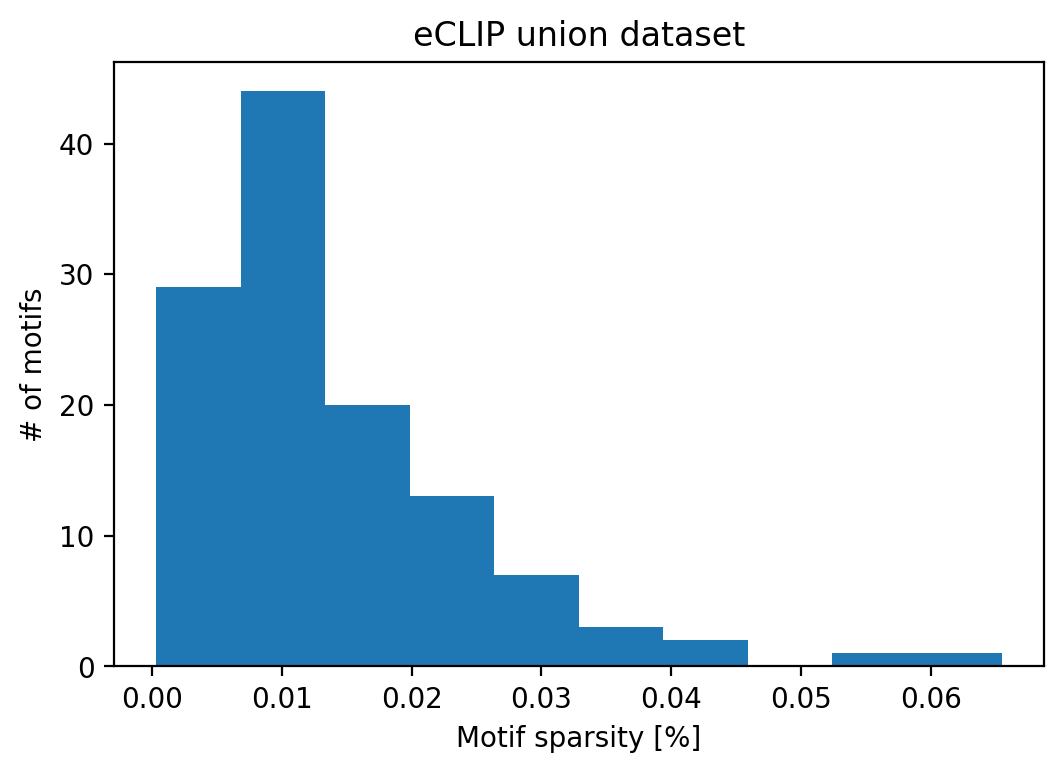

In [10]:
plt.figure(dpi=200)
plt.title("eCLIP union dataset")
plt.hist(binding_by_motif["1 union 2"] / total_size * 100)
plt.xlabel("Motif sparsity [%]")
plt.ylabel("# of motifs")